In [1]:
import pandas as pd
import numpy as np

### Reading Input

In [2]:
# read feature dataset
train_feat = np.load("datasets/train/train_feature.npz", allow_pickle=True)
train_feat_X = train_feat['features']
train_feat_Y = train_feat['label']

valid_feat = np.load("datasets/valid/valid_feature.npz", allow_pickle=True)
valid_feat_X = valid_feat['features']
valid_feat_Y = valid_feat['label']

test_feat_X = np.load("datasets/test/test_feature.npz", allow_pickle=True)['features']

In [3]:
print(f"Train dataset size: ")
print(f"train_feat_X: {train_feat_X.shape} train_feat_Y: {train_feat_Y.shape}")

print()
print("Test dataset size: ")
print(f"test_feat_X: {test_feat_X.shape}")

print()
print(f"Validation dataset size: ")
print(f"valid_feat_X: {valid_feat_X.shape} valid_feat_Y: {valid_feat_Y.shape}")

Train dataset size: 
train_feat_X: (7080, 13, 768) train_feat_Y: (7080,)

Test dataset size: 
test_feat_X: (2232, 13, 768)

Validation dataset size: 
valid_feat_X: (489, 13, 768) valid_feat_Y: (489,)


### Using TCN
* Initially, we tried a simple **KNN**. We chose `n_neighbors=1` based on elbow method. It returned very low score, so we decided to consider the input as a sequence of vectors and used models that learn patterns and dependencies among the feature vectors.
* We tried **LSTMs** because they are popular for sequence modeling. But, it gave accuracies of about 80% because its ability to capture long-range dependencies is not used here.
* We also tried **CNNs** because they capture local patterns well. It didn't give great results, may be because we couldn't get the right vector embeddings.
* Finally, we tried **TCN**
* TCNs are designed to capture temporal dependencies in sequences using convolutional layers, making them suitable for this task where order matters. TCN uses residual connections, which help in training deeper networks. *This allows the model to effectively model more complex sequential patterns without suffering from vanishing gradients.*
* **Observations**: 
    1. Even when we used a fraction of the 768 dimensions of the vector, we were not getting much drop in the accuracy. So, we concluded that many features are redundant. To reduce the number of parameters of the model, we used only the first 1/2.
    2. Many columns have the same vector in all the training inputs so it is better to remove them because it harms the classifier. These columns have same values in both the classes so, they do not improve inter-class variance therefore, do not help in separating the classes. Columns `[1, 7, 12]` are the only columns that do not have single unique values
* **Results**:
    1. We were getting validation accuracy of 98.57% on our best model (for fraction of dataset = 0.6, 0.8). 
    2. The full model had a validation accuracy of 97.14%. 
    3. For generating test predictions, we used the model trained on the full dataset anyway, considering that it would have generalized well.

In [4]:
# many columns have unique value
num_examples, num_vectors, dim_vectors = train_feat_X.shape
useful_cols = [i for i in range(num_vectors) if max([pd.Series(train_feat_X[:,i,j]).nunique() for j in range(dim_vectors)]) > 1]
useful_cols

[1, 7, 12]

### TCN Architecture, initializing weights, encapsulating TCNClassifier class with train_model and evaluate_model methods

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
import random

class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size]

class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = nn.Conv1d(n_inputs, n_outputs, kernel_size, stride=stride,
                               padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(n_outputs, n_outputs, kernel_size, stride=stride,
                               padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class TCNClassifier(nn.Module):
    def __init__(self, input_size, num_channels, num_classes=2, kernel_size=2, dropout=0.2):
        super(TCNClassifier, self).__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.fc = nn.Linear(num_channels[-1], num_classes)

    def forward(self, x):
        y = self.tcn(x)
        return self.fc(y[:, :, -1])

    def train_model(self, train_loader, criterion, optimizer, num_epochs=10):
        for epoch in range(num_epochs):
            self.train()
            running_loss = 0.0
            for inputs, labels in train_loader:
                inputs = inputs.permute(0, 2, 1)  
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')
    
    def evaluate_model(self, dataloader):
        self.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in dataloader:
                inputs = inputs.permute(0, 2, 1)
                outputs = self(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        return (100 * correct / total)


### Function to print Classification Report and Confusion matrix

In [6]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def print_classification_report_and_confusion_matrix(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_predictions = []

    with torch.no_grad():  # Disable gradient computation for evaluation
        for inputs, labels in dataloader:
            inputs = inputs.permute(0, 2, 1)  # Adjust input dimensions
            outputs = model(inputs)  # Forward pass through the model
            _, predicted = torch.max(outputs, 1)  # Get predicted class (index of max logit)

            # Store true labels and predicted labels for evaluation
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Print classification report
    print("Classification Report:")
    print("----------------------------------------------------------")
    print(classification_report(all_labels, all_predictions))
    # print("----------------------------------------------------------")

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()
    print("\n\n")
    


C:\Users\ASUS\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [7]:
import random
import numpy as np
import torch

def reset_random_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

### Function to prepare DataLoader and Train the model on different Fractions of Data

In [8]:
# Prepare DataLoader
def prepare_dataloader(X, y, batch_size=32):
    dataset = TensorDataset(X, y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Function to train on fractions of the data and return the best model
def train_on_fractions(fractions, X, y, valid_loader, input_size, num_channels, batch_size, num_epochs, learning_rate):
    best_acc = 0
    best_frac = 0
    valid_accuracies = []

    n_samples = len(X)
    full_model = None
    for fraction in fractions:
        # Subset of the data
        subset_size = int(n_samples * fraction)
        subset_X = X[:subset_size]
        subset_y = y[:subset_size]

        # Prepare DataLoader
        train_loader = prepare_dataloader(subset_X, subset_y, batch_size)

        best_model = None
        acc = 0.0
        
        # Reset seeds and initialize the model
        for seed in [0,1,2]:
            reset_random_seeds(seed)  # Reset with a seed value
            model = TCNClassifier(input_size=input_size, num_channels=num_channels)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
            # Train the model
            model.train_model(train_loader, criterion, optimizer, num_epochs)

            # Evaluate on validation data
            if model.evaluate_model(valid_loader) > acc:
                acc = model.evaluate_model(valid_loader)
                best_model = model
        valid_accuracies.append(acc)
        print("----------------------------------------------------------")
        print(f"Fraction: {fraction}, Validation Accuracy: {acc:.2f}%")
        print("----------------------------------------------------------")
        
        print_classification_report_and_confusion_matrix(best_model, valid_loader) #

        # Track best model
        if acc > best_acc:
            best_acc = acc
            best_frac = fraction
        
        full_model = best_model
        
        

    # Plot the accuracies for each fraction
    plt.plot(fractions, valid_accuracies, marker='o')
    plt.xlabel('Fraction of Training Data')
    plt.ylabel('Validation Accuracy (%)')
    plt.title('Validation Accuracy vs. Training Data Fraction')
    plt.show()
    
    print("=====================================================================")
    print(f"Best Validation accuracy was for fraction of {best_frac}: {best_acc:.2f}%")
    print("=====================================================================\n\n")
    
    return full_model


### Fixing Hyperparameters

----------------------------------------------------------
Fraction: 0.2, Validation Accuracy: 95.71%
----------------------------------------------------------
Classification Report:
----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       252
           1       0.95      0.96      0.96       237

    accuracy                           0.96       489
   macro avg       0.96      0.96      0.96       489
weighted avg       0.96      0.96      0.96       489



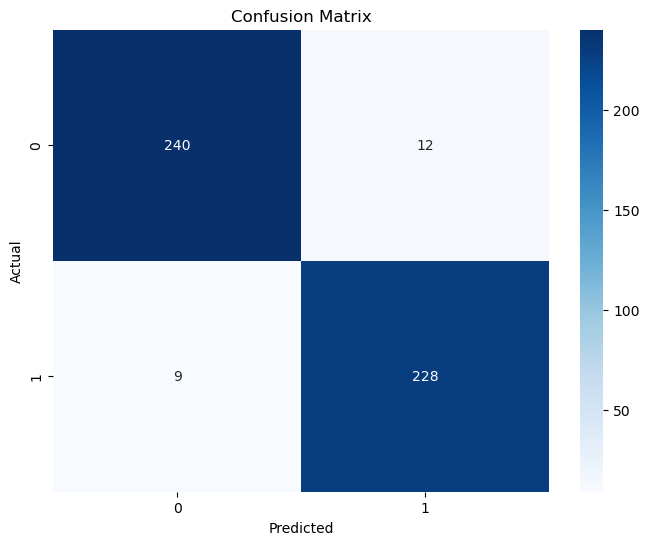




----------------------------------------------------------
Fraction: 0.4, Validation Accuracy: 97.14%
----------------------------------------------------------
Classification Report:
----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       252
           1       0.97      0.97      0.97       237

    accuracy                           0.97       489
   macro avg       0.97      0.97      0.97       489
weighted avg       0.97      0.97      0.97       489



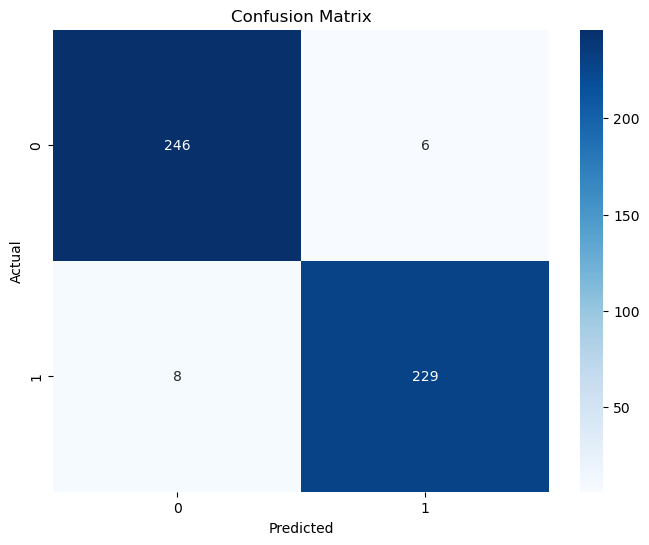




----------------------------------------------------------
Fraction: 0.6, Validation Accuracy: 98.57%
----------------------------------------------------------
Classification Report:
----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       252
           1       0.98      0.99      0.99       237

    accuracy                           0.99       489
   macro avg       0.99      0.99      0.99       489
weighted avg       0.99      0.99      0.99       489



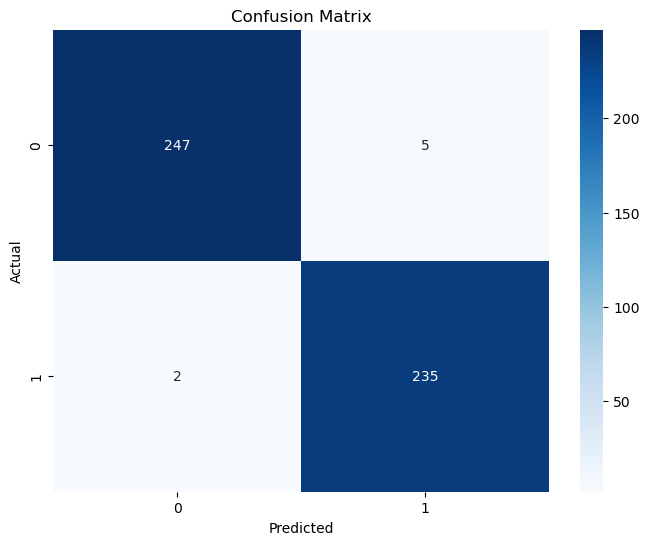




----------------------------------------------------------
Fraction: 0.8, Validation Accuracy: 97.14%
----------------------------------------------------------
Classification Report:
----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       252
           1       0.96      0.98      0.97       237

    accuracy                           0.97       489
   macro avg       0.97      0.97      0.97       489
weighted avg       0.97      0.97      0.97       489



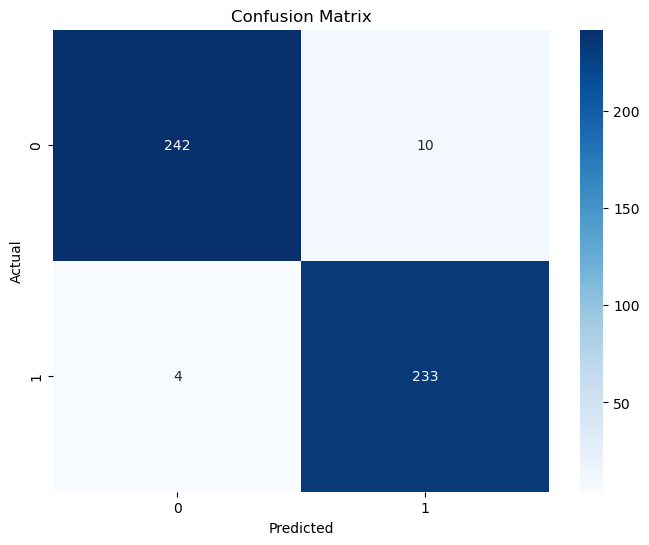




----------------------------------------------------------
Fraction: 1.0, Validation Accuracy: 98.16%
----------------------------------------------------------
Classification Report:
----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       252
           1       0.97      0.99      0.98       237

    accuracy                           0.98       489
   macro avg       0.98      0.98      0.98       489
weighted avg       0.98      0.98      0.98       489



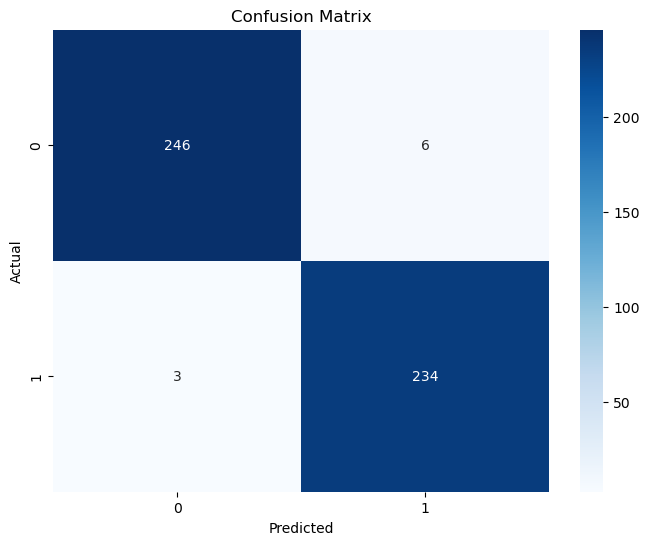

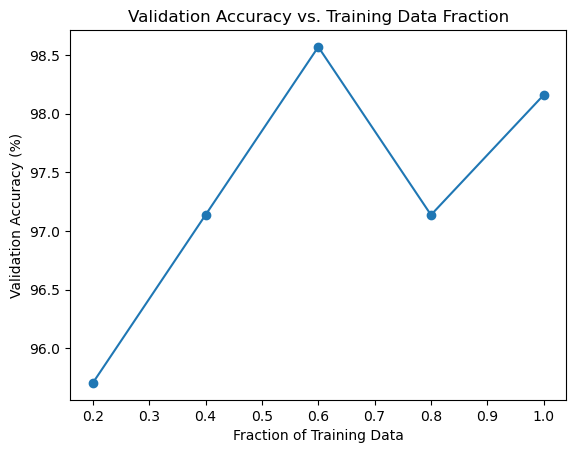

Best Validation accuracy was for fraction of 0.6: 98.57%




In [9]:
fractions = [0.2, 0.4, 0.6, 0.8, 1.0]

# Hyperparameters
n_vectors = 3
vector_dim = int(768 * 1/2) # int(768 * 3.8 / 5)
n_samples = 7080
num_channels = [4,16] # [4, 32]  # Number of channels for each layer in the TCN
batch_size = 64
num_epochs = 15
learning_rate = 0.0015

# Training and validation data converted to Tensors
X = torch.from_numpy(train_feat_X[:, useful_cols, : vector_dim]).float()
y = torch.from_numpy(train_feat_Y[:]).long()
valid_X = torch.from_numpy(valid_feat_X[:, useful_cols, : vector_dim]).float()
valid_y = torch.from_numpy(valid_feat_Y[:]).long()

# Prepare Validation DataLoader
valid_loader = prepare_dataloader(valid_X, valid_y, batch_size)

full_model = train_on_fractions(fractions, X, y, valid_loader, vector_dim, num_channels, batch_size, num_epochs, learning_rate)


### Returning Count of Parameters of a Pytorch model in Model summary

In [10]:
# # Function to calculate the number of parameters
# def count_parameters(model):
#     return sum(p.numel() for p in model.parameters()) # if p.requires_grad

# # Print the total number of learned parameters
# total_params = count_parameters(full_model)
# print(f'Total number of learned parameters: {total_params}')

In [11]:
!pip install torchinfo
!pip install torchsummary
from torchinfo import summary

In [12]:
summary(full_model)

Layer (type:depth-idx)                   Param #
TCNClassifier                            --
├─TemporalConvNet: 1-1                   --
│    └─Sequential: 2-1                   --
│    │    └─TemporalBlock: 3-1           4,652
│    │    └─TemporalBlock: 3-2           752
├─Linear: 1-2                            34
Total params: 9,222
Trainable params: 9,222
Non-trainable params: 0

### Generating Test Predictions and Saving text file

In [13]:
# Ensure the model is in evaluation mode
full_model.eval()

# Assuming test_X is a tensor of test data, and its shape is (batch_size, sequence_length, input_size)
test_X = torch.from_numpy(test_feat_X[:, useful_cols, : vector_dim]).float()

# We permute test_X to match the expected input shape for the TCN: (batch_size, input_size, sequence_length)
test_X = test_X.permute(0, 2, 1)

# Perform predictions on test_X
with torch.no_grad():
    outputs = full_model(test_X)
    _, predicted = torch.max(outputs, 1)  # Get the predicted class index

# Save predictions to a text file, one prediction per line
with open('pred_deepfeat.txt', 'w') as f:
    for pred in predicted:
        f.write(f"{pred.item()}\n")  # Convert the tensor element to a Python integer and write it to the file

print("Predictions successfully saved to 'pred_deepfeat.txt'")

Predictions successfully saved to 'pred_deepfeat.txt'
